## Imports 

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.pipeline import Pipeline
from numpy import sqrt


## Data preparation

In [4]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

# 0. Baseline

## 0.1 Linear Regression without Hyperparameter Optimization or Feature Selection

In [5]:
import pandas as pd
data_train = pd.read_csv('../data/processed/X_train_lr.csv')
data_test = pd.read_csv('../data/processed/X_test_lr.csv')
target_train = pd.read_csv('../data/processed/y_train_lr.csv')
target_test = pd.read_csv('../data/processed/y_test_lr.csv')


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

regressor = LogisticRegression()
regressor.fit(data_train, target_train.values.ravel())
drk_prediction = regressor.predict(data_test)

acc = accuracy_score(target_test, drk_prediction)
prc = precision_score(target_test, drk_prediction, pos_label='Y')
rec = recall_score(target_test, drk_prediction, pos_label='Y')
f1 = f1_score(target_test, drk_prediction, pos_label='Y')
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {prc:.3f}')
print(f'Recall: {rec:.3f}')
print(f'F1 Score: {f1:.3f}')



Accuracy: 0.727
Precision: 0.731
Recall: 0.719
F1 Score: 0.725


# 1. Linear Regression only with Random Search

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  
    'max_iter': [100, 200, 500]
}

logreg = LogisticRegression()

f1_scorer = make_scorer(f1_score, pos_label='Y')

random_search = RandomizedSearchCV(
    logreg,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring=f1_scorer, 
    random_state=42,
    n_jobs=-1
)

random_search.fit(data_train, target_train.values.ravel())

best_params = random_search.best_params_
best_score = random_search.best_score_

best_model = random_search.best_estimator_
drk_prediction = best_model.predict(data_test)

acc = accuracy_score(target_test, drk_prediction)
prc = precision_score(target_test, drk_prediction, pos_label='Y')
rec = recall_score(target_test, drk_prediction, pos_label='Y')
f1 = f1_score(target_test, drk_prediction, pos_label='Y')

print("Best parameters:", best_params)
print(f"Best cross-validated F1 score: {best_score:.3f}")
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {prc:.3f}')
print(f'Recall: {rec:.3f}')
print(f'F1 Score: {f1:.3f}')


Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 100}
Best cross-validated F1 score: 0.724
Accuracy: 0.727
Precision: 0.731
Recall: 0.719
F1 Score: 0.725


# 2. Hyperparameter tuning with Successive Halving


# 3. Grid Search

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'logreg__C': 1.0, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Test Set Performance:
Accuracy: 0.727
Precision: 0.731
Recall: 0.719
F1: 0.725


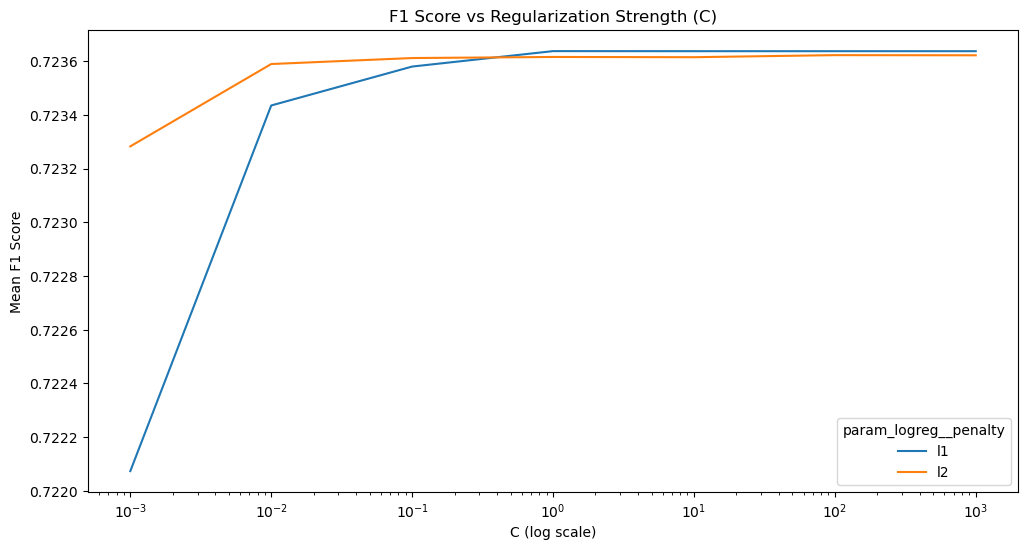

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

# Corrected pipeline and parameter grid
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=5000,
        tol=1e-3
    ))
])

param_grid = [
    # liblinear options (L1/L2)
    {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': np.logspace(-3, 3, 7),
        'logreg__solver': ['liblinear']
    },
    
    # saga options (elasticnet)
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__solver': ['saga'],
        'logreg__C': np.logspace(-3, 3, 7),
        'logreg__l1_ratio': [0.3, 0.5, 0.7]
    },
    
    # saga options (no regularization)
    {
        'logreg__penalty': [None],  # Python None, not string
        'logreg__solver': ['saga']
    }
]


grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'f1': f1_scorer,
        'precision': make_scorer(precision_score, pos_label='Y', average='binary'),
        'recall': make_scorer(recall_score, pos_label='Y', average='binary')
    },
    refit='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

grid_search.fit(data_train, target_train.values.ravel())




grid_search.fit(data_train, target_train.values.ravel())

best_model = grid_search.best_estimator_
drk_prediction = best_model.predict(data_test)

metrics = {
    'accuracy': accuracy_score(target_test, drk_prediction),
    'precision': precision_score(target_test, drk_prediction, pos_label='Y'),
    'recall': recall_score(target_test, drk_prediction, pos_label='Y'),
    'f1': f1_score(target_test, drk_prediction, pos_label='Y')
}

results_df = pd.DataFrame(grid_search.cv_results_)
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")
print("Test Set Performance:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.3f}")

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df[results_df.param_logreg__solver == best_params['logreg__solver']],
    x='param_logreg__C', 
    y='mean_test_f1',
    hue='param_logreg__penalty'
)
plt.xscale('log')
plt.title('F1 Score vs Regularization Strength (C)')
plt.xlabel('C (log scale)')
plt.ylabel('Mean F1 Score')
plt.show()


In [20]:
coefficients = best_model.named_steps['logreg'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': data_train.columns,
    'Weight': coefficients
}).sort_values('Weight', ascending=False)

print(feature_importance.head(10))

             Feature    Weight
20         gamma_GTP  0.616515
28          sex_Male  0.497438
12         HDL_chole  0.401826
21  SMK_stat_type_cd  0.380405
1             height  0.218855
27     AST_ALT_ratio  0.193163
18          SGOT_AST  0.191820
22               BMI  0.108928
14      triglyceride  0.108210
25        vision_avg  0.106017
